In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import sys
sys.path.insert(0, '../..')
import leximin_assignment
import bottleneck_assignment
import assignment

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

from sklearn.neighbors import KernelDensity

In [2]:
df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = df['Real'].value_counts()
types = ['ES', 'PSH', 'TH', 'RRH', 'PREV']

increase_from_best_df = df.copy()
increase_from_best_df['Best'] = increase_from_best_df[types].min(axis=1)
for type_ in types:
    increase_from_best_df[type_] = df[type_] - increase_from_best_df['Best']
    
cost_matrix = df[types].to_numpy()
increase_matrix = increase_from_best_df[types].to_numpy()
capacities = capacity_df.sort_index().to_numpy()

cost_matrix

array([[0.42500842, 0.27180128, 0.35001742, 0.39762604, 0.29163674],
       [0.32754978, 0.18874302, 0.26654296, 0.337444  , 0.21823367],
       [0.18697342, 0.76077218, 0.13780471, 0.17875879, 0.10616787],
       ...,
       [0.54716862, 0.25996667, 0.4647149 , 0.51933195, 0.40655856],
       [0.4620856 , 0.4647149 , 0.41079509, 0.43719035, 0.31188434],
       [0.19867989, 0.1473215 , 0.1473215 , 0.16775582, 0.10337189]])

In [3]:
increase_matrix

array([[0.15320713, 0.        , 0.07821614, 0.12582476, 0.01983546],
       [0.13880676, 0.        , 0.07779993, 0.14870098, 0.02949065],
       [0.08080555, 0.65460431, 0.03163684, 0.07259092, 0.        ],
       ...,
       [0.28720194, 0.        , 0.20474822, 0.25936527, 0.14659188],
       [0.15020126, 0.15283056, 0.09891075, 0.12530601, 0.        ],
       [0.095308  , 0.04394961, 0.04394961, 0.06438393, 0.        ]])

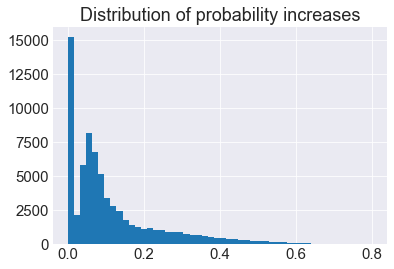

In [4]:
plt.hist(increase_matrix.flatten(), bins=50)
plt.title('Distribution of probability increases')
plt.show()

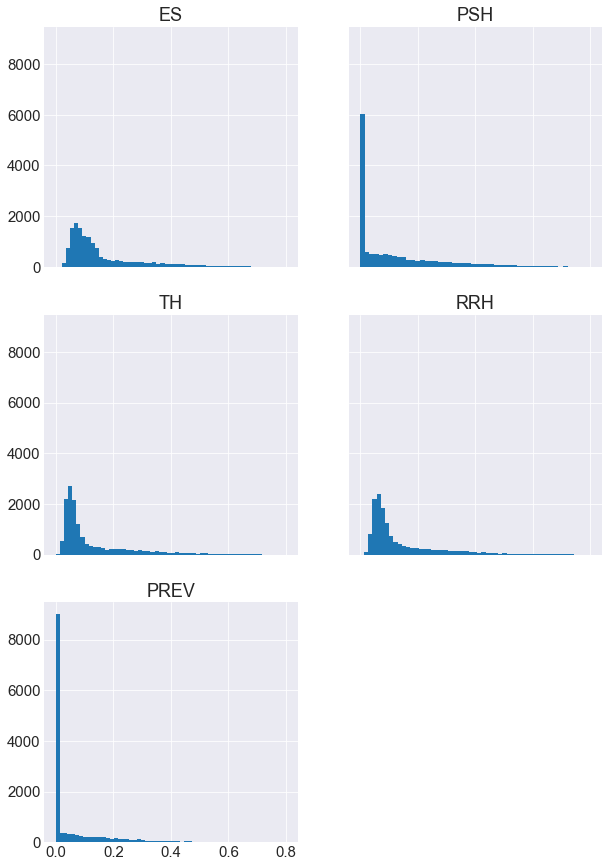

In [6]:
f, ax = plt.subplots(3, 2, figsize=(10, 15), sharex=True, sharey=True)

for i in range(5):
    ax[i // 2][i % 2].hist(increase_matrix[:, i], bins=50)
    ax[i // 2][i % 2].set_title(types[i])

ax[-1][-1].axis('off')
    
plt.show()

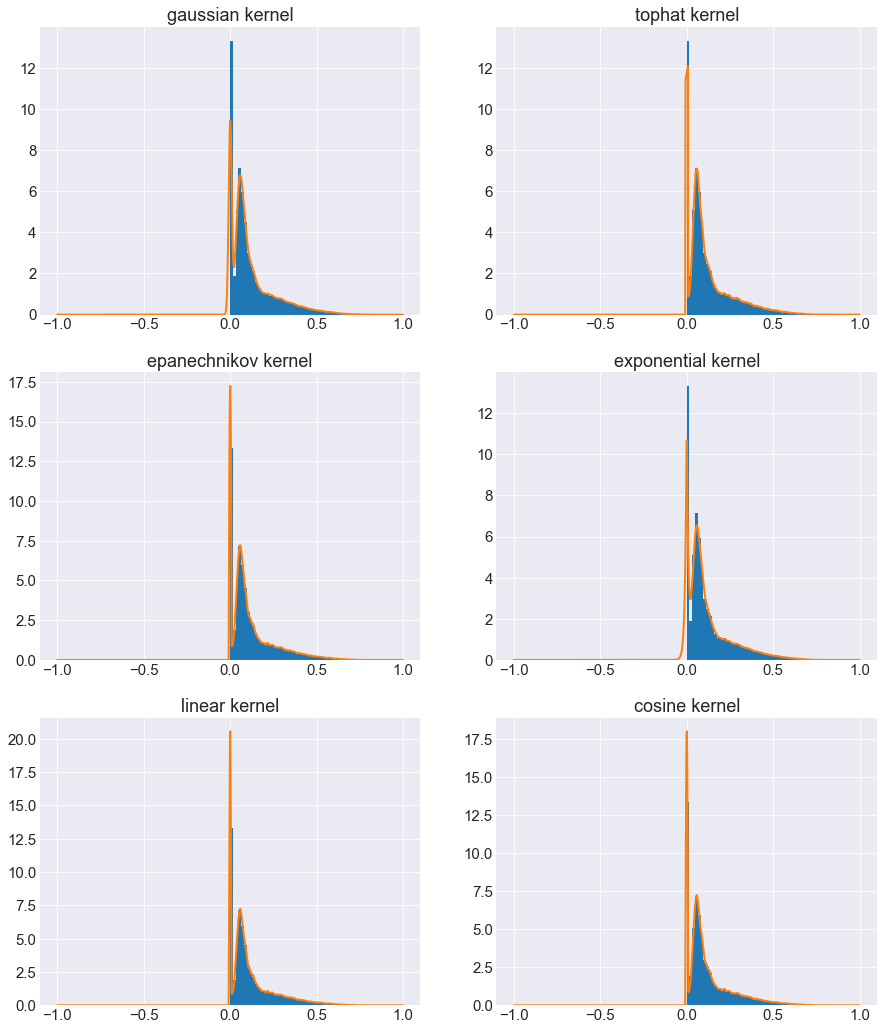

In [8]:
kernels = [
    'gaussian', 'tophat', 'epanechnikov',
    'exponential', 'linear', 'cosine'
]

fig, ax = plt.subplots(len(kernels) // 2, 2, figsize=(15, 3 * len(kernels)))
x_plot = np.linspace(-1, 1, 1000)
bandwidth = 0.9 \
            * min(increase_matrix.std(), np.subtract(*np.percentile(increase_matrix, [75, 25])) / 1.34) \
            * increase_matrix.size ** (-1 / 5)

for i, kernel in enumerate(kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(increase_matrix.flatten()[:, np.newaxis])
    log_dens = kde.score_samples(x_plot[:, np.newaxis])
    
    ax[i // 2][i % 2].hist(increase_matrix.flatten(), density=True, bins=50)
    ax[i // 2][i % 2].plot(x_plot, np.exp(log_dens), linewidth=2)
    ax[i // 2][i % 2].set_title(f'{kernel} kernel')
    
plt.show()

In [7]:
corr_matrix = np.corrcoef(increase_matrix.T)
corr_matrix

array([[ 1.        , -0.45496729,  0.96343196,  0.97822065,  0.96893152],
       [-0.45496729,  1.        , -0.43251926, -0.44063177, -0.41450405],
       [ 0.96343196, -0.43251926,  1.        ,  0.97027065,  0.98592781],
       [ 0.97822065, -0.44063177,  0.97027065,  1.        ,  0.97673103],
       [ 0.96893152, -0.41450405,  0.98592781,  0.97673103,  1.        ]])

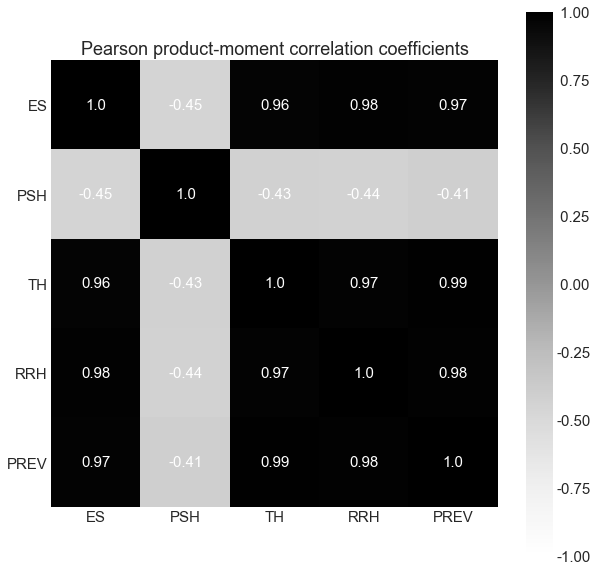

In [8]:
ticks = [i for i in range(5)]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr_matrix)

im.set_clim(-1, 1)
ax.grid(False)

ax.xaxis.set(ticks=ticks, ticklabels=types)
ax.yaxis.set(ticks=ticks, ticklabels=types)
# ax.set_ylim(2.5, -0.5)

for i in range(5):
    for j in range(5):
        ax.text(j, i, corr_matrix[i, j].round(2), ha='center', va='center',
                color='w')

cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.title('Pearson product-moment correlation coefficients')

plt.show()